In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from stop_words import get_stop_words
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from umap import UMAP
from collections import Counter

In [2]:
df = pd.read_csv('../dataset/movies_complete.csv')
df.dropna(subset=['genre'], inplace=True)
df['text_length'] = df.text.apply(lambda x: len(x.split()))
df = df[df['text_length'] >= 3000]

In [3]:
def aggregate_by_label(df: pd.DataFrame, label: str, min_threshold: int = 0):
    
    top_labels = df[label].value_counts()[df[label].value_counts() > min_threshold]
    
    entries = []
    for l in top_labels.index:
        label_df = df[df[label] == l]
        all_texts = []
        for text in label_df.text:
            all_texts.append(text)
        entry = {}
        
        conctanated_text = " ".join(all_texts)
        entry['label'] = l
        entry['text'] = conctanated_text
        entry['n_texts'] = len(all_texts)
        entry['n_tokens'] = len(conctanated_text.split())
        entry['instances'] = ", ".join(label_df.filename.to_list())
        
        entries.append(entry)
    return pd.DataFrame.from_records(entries)

In [4]:
def get_cluster_dfs(df, cluster):
    return[df[cluster == i] for i in np.unique(cluster)]

In [5]:
from plotly.colors import qualitative 

def plotly_color_categorical_values(values, cmap=qualitative.Light24):
    uniq = np.unique(values)
    if len(uniq) > len(cmap):
        print("Need more colors than current cmap holds")
        return
    categories_color = {cat: cmap[index] for index, cat in enumerate(uniq)}
    return [categories_color[cat] for cat in values]

In [36]:
aggr = aggregate_by_label(df, 'genre', 9)

In [149]:
tfidf = TfidfVectorizer(
    #stop_words=get_stop_words('de'),
    max_features=250)

X = tfidf.fit_transform(aggr.text)
X = X.todense()

In [172]:
Xr = UMAP(n_components=2, n_neighbors=20).fit_transform(X)
#Xr = PCA(n_components=2).fit_transform(X)

In [173]:
fig = go.Figure(data=go.Scatter(x=Xr[:, 0],
                                y=Xr[:, 1],
                                mode='markers',
                                text=[f'{label}|{n_token}' for label, n_token in zip(aggr.label, aggr.n_texts)],
                                marker_color=aggr.n_tokens))


fig.show()

In [174]:
single_labels = aggr.label[aggr.label.str.split(',').apply(lambda x: len(x)) == 1]
n_single_labels = len(single_labels)
single_labels, n_single_labels

(0           Drama
 1          Comedy
 6          Horror
 11    Documentary
 13       Thriller
 18         Action
 30         Family
 64          Crime
 Name: label, dtype: object,
 8)

In [187]:
from sklearn.mixture import GaussianMixture

clu = GaussianMixture(n_components=n_single_labels)
Xpca = PCA(n_components=50).fit_transform(X)

cluster = clu.fit_predict(Xpca)
probs = clu.predict_proba(Xpca)

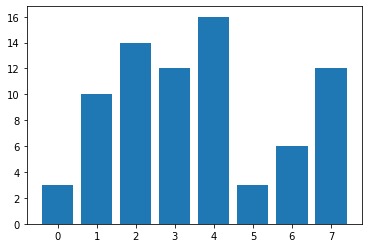

In [188]:
cluster_counter = Counter(cluster)
plt.bar(cluster_counter.keys(), cluster_counter.values())
plt.show()

In [189]:
probs.argmax(axis=1)

array([1, 3, 1, 1, 1, 1, 4, 2, 4, 7, 3, 0, 4, 4, 7, 7, 4, 6, 4, 4, 2, 0,
       2, 4, 7, 2, 3, 4, 6, 4, 3, 3, 5, 2, 4, 6, 2, 6, 7, 7, 1, 7, 4, 5,
       4, 1, 4, 7, 3, 2, 4, 2, 1, 1, 2, 2, 3, 7, 3, 2, 6, 0, 7, 3, 4, 6,
       2, 5, 2, 7, 3, 7, 2, 3, 3, 1])

In [190]:
fig = go.Figure(data=go.Scatter(x=Xr[:, 0],
                                y=Xr[:, 1],
                                mode='markers',
                                text=[f'{label}|{n_token}' for label, n_token in zip(aggr.label, aggr.n_texts)],
                                marker_color=plotly_color_categorical_values(cluster)))


fig.show()

In [191]:
dfs = get_cluster_dfs(aggr, cluster)

In [194]:
for cluster_df in dfs:
    print(cluster_df.label)
    print(f'Total number of movies in cluster => {cluster_df.n_texts.sum()}')
    print(f'Total number of tokens in cluster => {cluster_df.n_tokens.sum()}')
    print('#'*60)

11                Documentary
21    Biography,Drama,History
61          Drama,History,War
Name: label, dtype: object
Total number of movies in cluster => 106
Total number of tokens in cluster => 1019041
############################################################
0                      Drama
2               Comedy,Drama
3              Drama,Romance
4       Comedy,Drama,Romance
5             Comedy,Romance
40     Drama,Horror,Thriller
45              Drama,Family
52    Drama,Romance,Thriller
53      Comedy,Drama,Fantasy
75               Drama,Music
Name: label, dtype: object
Total number of movies in cluster => 906
Total number of tokens in cluster => 7694409
############################################################
7              Drama,Thriller
20        Crime,Drama,Mystery
22            Biography,Drama
25    Horror,Mystery,Thriller
33    Biography,Drama,Romance
36     Drama,Mystery,Thriller
49           Mystery,Thriller
51     Biography,Comedy,Drama
54       Drama,Horror,Mystery
55